In [1]:
#https://arxiv.org/pdf/1509.02971.pdf
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
#tf.enable_eager_execution()
import 
import pandas as pd
import numpy as np

In [2]:
def load_data():
    df = pd.read_csv('../data/MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz')
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna(axis=0)
    return df

df = load_data()

In [8]:
starting = 0
env=gym.make('Emulator_Accelerator',df[starting:starting+5000])
print(env.state)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

[-0.2703125]
Size of State Space ->  1
Size of Action Space ->  1
Max Value of Action ->  103.4000015258789
Min Value of Action ->  103.30000305175781


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Takes (s,a,r,s') obervation tuple as input
        
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            # critic model estimates a state value
            # use Bellman equation to converge
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            # take actions where the critic model returns the maximum values
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )


# soft update the target parameters with `tau`.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

In [11]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    #last_init = tf.random_uniform_initializer(minval=0, maxval=0.003)
    inputs = layers.Input(shape=(1,num_states))
    out = layers.Dense(512, activation="tanh")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="tanh")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    #out = layers.LSTM(56, return_sequences=True)(inputs)
    #out = layers.GaussianNoise(0.1)(out)
    #out = layers.LSTM(56, return_sequences=True)(out)
    #out = layers.GaussianNoise(0.1)(out)
    #outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    
    scale = (upper_bound-lower_bound)/2
    outputs = outputs * scale + (upper_bound+lower_bound)/2
    
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out   = layers.Dense(16, activation="relu")(state_input)
    state_out   = layers.BatchNormalization()(state_out)
    state_out   = layers.Dense(32, activation="relu")(state_out)
    state_out   = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="relu")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
def policy(state, noise_object):
    #print("policy-->state: ",state)
    sampled_actions = tf.squeeze(actor_model(state))
    #print("sampled_actions: ",sampled_actions)
    noise = noise_object()
    
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    #print("sampled_actions w/ noise: ",sampled_actions)
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [1]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.002

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200
# Discount factor for future rewards
gamma = 0.995
# Used to update target networks
tau = 0.05

buffer = Buffer(5000, 64)

UndefVarError: UndefVarError: np not defined

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide


step-->action/reward:  103.32268875313545 -0.6794849147418249
step-->action/reward:  103.3008847833442 -0.7994738026125106
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.30000305175781 -0.8076153547555123
step-->action/reward:  103.3148565853153 -0.7549242485298535
step-->action/reward:  103.32243308787237 -0.6862130295878118
step-->action/reward:  103.3290719124896 -0.625024771495646
Episode * 0 * Ep. Reward is ==> -8.390812895500721
step-->action/reward:  103.36989950911018 -0.22152708257280226
step-->action/reward:  103.37679453145789 -0.1669490203032949
step-->action/reward:  103.34669008328375 -0.10275115102054838
step-->action/reward:  103.35167499528357 -0.3673603902752348
step-->action/reward:

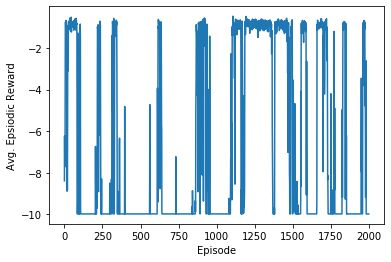

In [18]:
starting = 0
#print(df[starting:starting+5000]["B:VIMIN"][0])
env=emulator(df[starting:starting+5000])

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 20 min to train
for ep in range(total_episodes):
    env.reset(df[starting:starting+5000])
    prev_state = env.state
    episodic_reward = 0
    #print (prev_state)
    st = 0
    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        #print (prev_state)

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        #print('from policy network-->action: ',action)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action[0])
        
        current_exp=(prev_state, action[0], reward, state)
        #print (current_exp)
        buffer.record(current_exp)
        episodic_reward += reward

        buffer.learn()
        update_target(tau)

        # End this episode when `done` is True
        if done or st==10:
            break

        prev_state = state
        st+=1

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Ep. Reward is ==> {}".format(ep, episodic_reward))
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    starting += 1

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
#plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

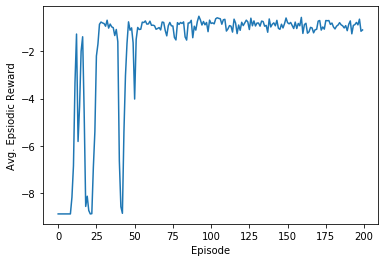

In [16]:
plt.plot(ep_reward_list)
#plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [13]:
import random, gym
from gym import spaces
from gym.utils import seeding
import numpy as np

class emulator(gym.Env):
  def __init__(self,df):
    self.df = df
    
    self.min_BIMIN = 103
    self.max_BIMIN = 104
    self.max_IMINER = 1
    
    self.low_state = np.array(
      [self.min_BIMIN,-self.max_IMINER], dtype=np.float32
    )
    
    self.high_state = np.array(
      [self.max_BIMIN, self.max_IMINER], dtype=np.float32
    )
    
    self.observation_space = spaces.Box(
      low   = -self.max_IMINER, 
      high  =  self.max_IMINER, 
      shape = (1,),
      dtype = np.float32
    )
    
    self.action_space = spaces.Box(
      low   = self.min_BIMIN,
      high  = self.max_BIMIN,
      shape = (1,),
      dtype = np.float32
    )
    
    #print(df)
    self.state = [self.df["B:IMINER"][0]]
    #print("end of init-->state:", self.state)
    #self.state = self.reset(self.df)
    #print(self.state)
    
  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
      
  def predict(self,x):
    #print ("predict-->action x: ",x)
    y=self._BIMINER_linear(x)
    r=self._random_from_cdf(x)
    #print("y+r: ",y,r)
    return y+r
  
  def step(self,action):
    self.err = self.predict(action)
    #print("step-->error: ",self.err)
    #print("error>max_IMINER: ", self.err, self.max_IMINER)
    self.done = bool(
      abs(self.err) >= self.max_IMINER*20 # fail
    )
    
    self.reward = 0
    if self.done:
      self.reward = -10
    self.reward = -abs(self.err)
    
    print("step-->action/reward: ",action,self.reward)
    self.state = np.array([self.err])
    #print("end of step-->\n")
    return self.state, self.reward, self.done, {}
  
  def reset(self,df):
    self.seed()
    self.df = df
    self.df = self._prepData(self.df)
    init = self.np_random.uniform(low=self.min_BIMIN, high=self.max_BIMIN) #random init. control
    #print ('reset-->init: random action:',init)
    self.err = self.predict(init)
    self.state = np.array([self.err])
    #print('end of reset-->state:',self.state)
    
  def _prepData(self,df):
    self.m, self.b = self._LinearRegression(df)
    df["IMINER_linear"]=self._BIMINER_linear(df["B:VIMIN"]) # the linear regression portion
    df["IMINER_std"]=df["B:IMINER"]-df["IMINER_linear"] # calculate the deviation 
    return df
    
  def _LinearRegression(self,df):
    x_min = df["B:VIMIN"].min()
    x_max = df["B:VIMIN"].max()
    y_min = df[df["B:VIMIN"]==x_min]["B:IMINER"].max()
    y_max = df[df["B:VIMIN"]==x_max]["B:IMINER"].min()
    m=(y_min-y_max)/(x_min-x_max)
    b=y_min-m*x_min
    return m,b
  
  def _BIMINER_linear(self,x):
    y=self.m*x+self.b
    return y
  
  def _random_from_cdf(self,x):
    sampling_window = 0.005
    error_window = 0.01
    
    nbins = 100
    df = self.df
    state = self.state
    #print("state: ==>", state)
    error = state[0]
    #print(error)
    
    #filter according to x-axis:
    y_std = df[df["B:VIMIN"].between(x-sampling_window,x+sampling_window)]
    #y_std = y_std[y_std["B:IMINER"].between(error-error_window,error+error_window)]
    
    # get the y-axis noise value according to the x-axis filtering
    hist, bins = np.histogram(y_std["IMINER_std"], bins=nbins)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
  
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
  
    values = np.random.rand(len(y_std)*10)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
  
    if len(random_from_cdf)>0:
      i=random.randint(0,len(random_from_cdf)-1)
      return random_from_cdf[i]
    else:
      return 0